In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid' if 'seaborn-v0_8-whitegrid' in plt.style.available else 'seaborn-whitegrid')
sns.set_context("talk")

In [3]:
CSV_PATH = "pspc_2020_2021_by_department_enriched.csv"

In [4]:
# Hàm làm sạch số 
def clean_numeric_column(series):
    s = series.astype(str).str.strip()
    s = s.str.replace(r'[^\d\.\-]', '', regex=True)
    s = s.replace('', np.nan)
    return pd.to_numeric(s, errors='coerce')
  
  # Đọc file
df = pd.read_csv(CSV_PATH)

# Xác định cột group (department)
possible_keys = [c for c in df.columns if any(k in c.lower() for k in ['department','dept','ministry','organization','org','agency'])]
group_col = possible_keys[0]

# Xác định cột amount
amt_col = [c for c in df.columns if 'payments' in c.lower() and 'amount' in c.lower()][0]

# Xác định cột volume nếu có
vol_col_candidates = [c for c in df.columns if 'volume' in c.lower()]
vol_col = vol_col_candidates[0] if vol_col_candidates else None

# Làm sạch dữ liệu số
df[amt_col] = clean_numeric_column(df[amt_col])
if vol_col:
    df[vol_col] = clean_numeric_column(df[vol_col])

# Loại bỏ missing
df_clean = df.dropna(subset=[amt_col, group_col]).copy()

In [5]:
# Tính tổng chi theo bộ ngành
totals = df_clean.groupby(group_col)[amt_col].sum()
totals_df = totals.reset_index().rename(columns={amt_col: 'total_amount'})

In [6]:
# Thống kê 
n = len(totals_df)
xbar = totals_df['total_amount'].mean()
s = totals_df['total_amount'].std(ddof=1)
variance = s**2
sem = s / math.sqrt(n)

alpha = 0.05
z_crit = stats.norm.ppf(1 - alpha/2)
margin = z_crit * sem
ci_lower = xbar - margin
ci_upper = xbar + margin

In [9]:
# Mô tả 
desc = totals_df['total_amount'].describe(percentiles=[0.25, 0.5, 0.75])

print("Cỡ mẫu (n) =", n)
print("Trung bình mẫu (x̄) =", xbar)
print("Độ lệch chuẩn mẫu (s) =", s)
print("Phương sai mẫu (s²) =", variance)
print("Sai số chuẩn (SEM) =", sem)
print("Khoảng tin cậy 95% = (", ci_lower, ";", ci_upper, ")")
print("\nThống kê mô tả:")
print(desc)

Cỡ mẫu (n) = 110
Trung bình mẫu (x̄) = 9591855776.555365
Độ lệch chuẩn mẫu (s) = 45015002399.190186
Phương sai mẫu (s²) = 2.0263504409990983e+21
Sai số chuẩn (SEM) = 4292012074.2428427
Khoảng tin cậy 95% = ( 1179666689.8283405 ; 18004044863.282387 )

Thống kê mô tả:
count    1.100000e+02
mean     9.591856e+09
std      4.501500e+10
min      6.806000e+01
25%      4.359428e+06
50%      6.941582e+07
75%      1.294083e+09
max      3.037579e+11
Name: total_amount, dtype: float64


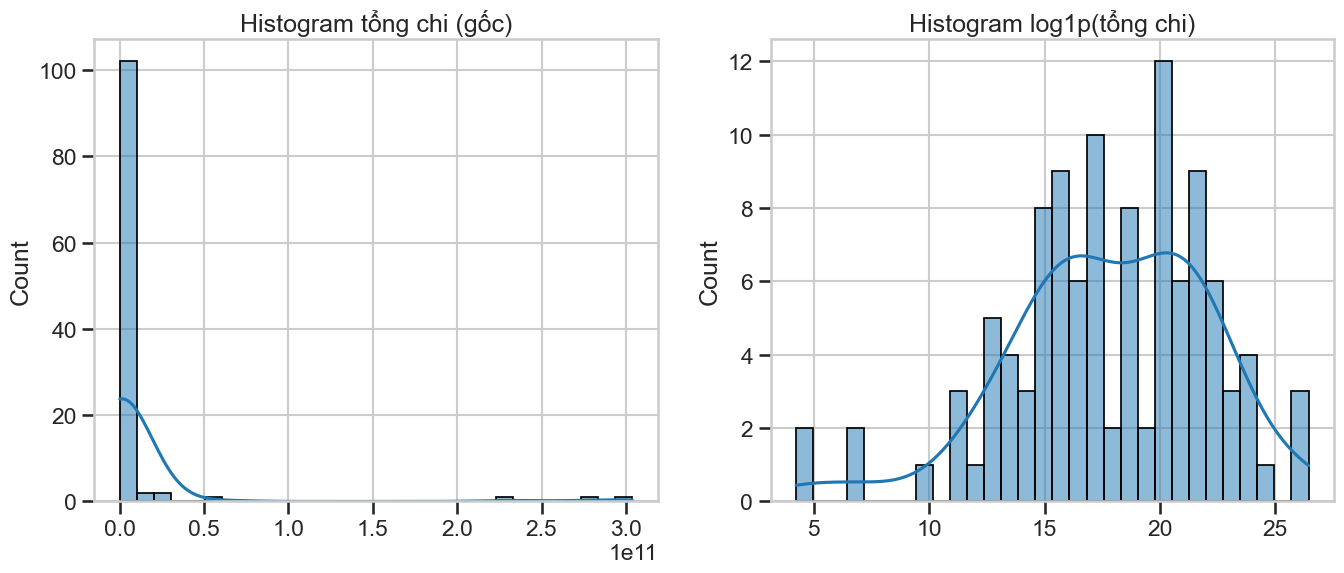

In [10]:
# Histogram trước và sau log1p 
vals = totals_df['total_amount'].values
vals_log = np.log1p(vals)

fig, axes = plt.subplots(1,2, figsize=(16,6))
sns.histplot(vals, bins=30, ax=axes[0], kde=True)
axes[0].set_title("Histogram tổng chi (gốc)")
sns.histplot(vals_log, bins=30, ax=axes[1], kde=True)
axes[1].set_title("Histogram log1p(tổng chi)")
plt.show()

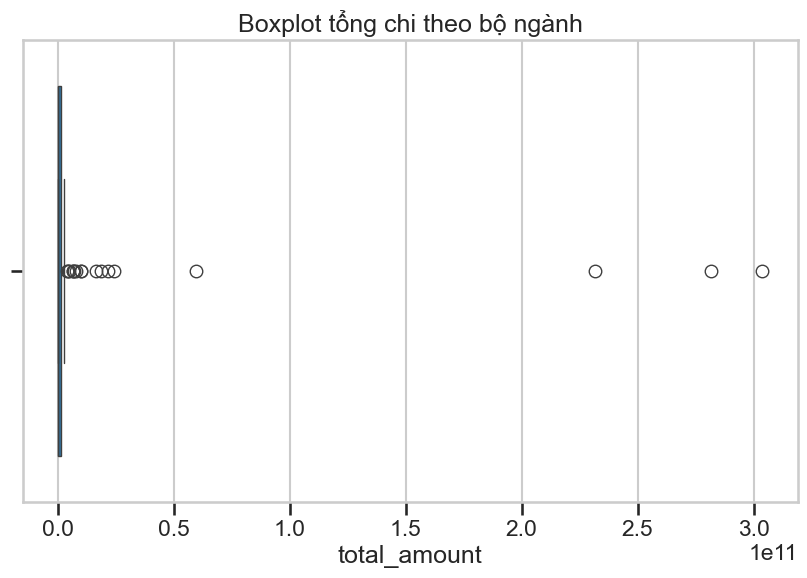

In [11]:
# Boxplot 
plt.figure(figsize=(10,6))
sns.boxplot(x=totals_df['total_amount'])
plt.title("Boxplot tổng chi theo bộ ngành")
plt.show()

In [12]:
# Phát hiện ngoại lai với z-score 
z_scores = (vals_log - vals_log.mean()) / vals_log.std(ddof=1)
totals_df['z_log'] = z_scores
outliers = totals_df[np.abs(z_scores) >= 3]
print("\nNgoại lai (|z|>=3):")
print(outliers[[group_col, 'total_amount', 'z_log']])



Ngoại lai (|z|>=3):
    DepartmentNumber-Numéro-de-Ministère  total_amount     z_log
86                                   143         80.00 -3.094553
91                                   149         68.06 -3.131349


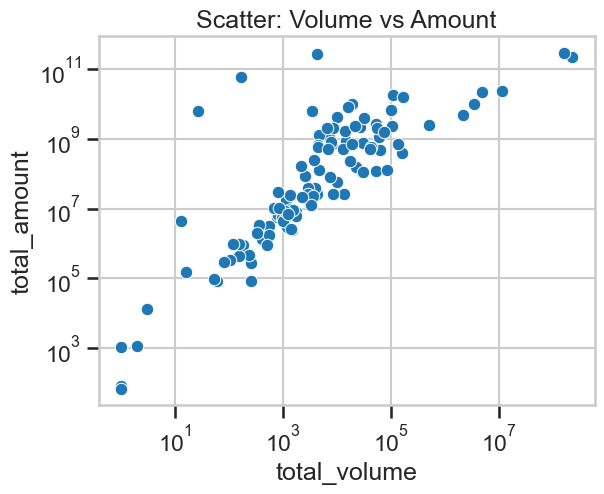

In [13]:
# Scatter volume vs amount 
if vol_col:
    totals_vol = df_clean.groupby(group_col)[vol_col].sum().reindex(totals_df[group_col]).values
    totals_df['total_volume'] = totals_vol
    sns.scatterplot(x='total_volume', y='total_amount', data=totals_df)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Scatter: Volume vs Amount")
    plt.show()